## Bias, Variance and Automatic Differentiation

Author: Omar Al-Ghattas

## Introduction

In this lab we will continue our discussion of bias and variance through a detailed example using simulated data. We will then cover the basics of automatic differentiation and `PyTorch`, and explore how these ideas can be used to solve problems in machine learning.

### Acknowledgements:
Autograd Theory:

    1. https://people.cs.umass.edu/~domke/courses/sml2011/08autodiff_nnets.pdf
    2. Mathematics for Machine Learning by Marc Peter Deisenroth, A. Aldo Faisal, and Cheng Soon Ong.

## Bias-Variance Decomposition

We first explore the concepts of bias and variance, as well as the idea of a bias-variance decomposition. We begin with a short mathematical explanation of bias and variance, and then reinforce the theory with code.

We begin by discussing the Bias-Variance decomposition, a central theme in Statistics and Machine Learning. Assume that we are interested in estimating some population parameter $\theta$, and we have access to a finite dataset $D = \{X_1,\dots, X_n\}$, which we assume is independently sampled. To give a concrete example, suppose we are interested in estimating the average WAM of students in COMP9417, but we only have access to the WAM of a small subset of 22 randomly sampled students. The population here is all students in the course, and we must infer information about the true mean using only information about a small subset. 

When $\theta$ denotes the population mean, one standard estimator to use is the sample-mean:

$$
\hat{\theta} = \frac{1}{n} \sum_{i=1}^n X_i.
$$

However, this is only one estimator, and we could use others, for example, the sample median:

$$
\tilde{\theta}=\text{median}(X_1,\dots,X_n)
$$

or, for a silly example, we could simply choose to estimate $\theta$ by the second datapoint

$$
\dot{\theta} = X_2.
$$

These are all valid estimators of $\theta$, but of course some are better than others (obviously $\dot{\theta}$ will be a useless estimator in almost all examples. Bias and Variance of estimators are two metrics we may use to quantify how good an estimator actually is. 

### Bias

We first start with the mathematical definition and then explain the intuition behind that definition. Given an estimator $\hat{\theta}$ for population parameter $\theta$, we define the bias of $\hat{\theta}$ as

$$
\text{Bias}(\hat{\theta}) = \mathbb{E}[\hat{\theta}] - \theta,
$$

where $\mathbb{E}$ denotes expectation. The bias simply measures how far away the expected value of our estimator is from the truth. An estimator with zero bias is called an unbiased estimator. All else equal, an unbiased estimator is better than a biased estimator.

### Variance

The variance of an estimator $\hat{\theta}$, is denoted by $\text{Var}(\hat{\theta})$ and is defined in the usual way

$$
\text{Var}(\hat{\theta}) = \mathbb{E} [ ( \hat{\theta} - \mathbb{E}[\hat{\theta} ] )^2]
$$

### Interpretation - An important point
An important question arises here: what does it mean to take an expectation (or variance) of an estimator $\hat{\theta}$? How do we compute these values? For the purpose of this lab, we will side-step the proper mathematical definitions and try to answer this question in a more intuitive sense. We can think of our dataset $D$ as being just one of infinitely many datasets. Let's imagine that we have access to a black-box $B$ that we can query datasets from. We label these datasets: $D_1,D_2,\dots, D_{\infty}$, and for simplicity we assume that each dataset consists of the same number $n$ of samples. For clarity, we have:

\begin{align*}
D_1 &= \{ X^{(1)}_1, X^{(1)}_2,\dots,X^{(1)}_n \} \\
D_2 &= \{ X^{(2)}_1, X^{(2)}_2,\dots,X^{(2)}_n\}\\
D_3 &= \{ X^{(3)}_1, X^{(3)}_2,\dots,X^{(3)}_n\}\\
&  \vdots
\end{align*}

Now, assume that we have chosen an estimator $\hat{\theta}$. This estimator is a function of the dataset, so for each dataset, we can compute a new estimate. For example, if we wish to use the sample mean, then our estimate for each dataset would just be the sample-mean of each dataset:

\begin{align*}
\hat{\theta}_1 &= \overline{X}_1 = \frac{1}{n} \sum_{i=1}^n X_i^{(1)}\\
\hat{\theta}_2 &= \overline{X}_2 = \frac{1}{n} \sum_{i=1}^n X_i^{(2)}\\
&  \vdots
\end{align*}

and so on. Now, we can think of the quantity $\mathbb{E}[\hat{\theta}]$ as being the average value of $\hat{\theta}$ over an infinite number of datasets. Similarly, we can think of $\text{Var}(\hat{\theta})$ as the variance of $\hat{\theta}$ over an infinite number of datasets. 

Note that this is a purely theoretical construction because we do not have access to a black-box $B$ that allows us to generate multiple datasets (in fact we will usually only have access to a single dataset), and secondly even if we did have access to $B$, we cannot sample an infinite number of datasets. This theoretical construction does however help us understand the benefits of different estimators and has led to the proposal of many important algorithms in machine learning that have had great empirical success.

### Bias-Variance for Learning Functions
Up to this point, you should have understood the basic concepts underlying the bias-variance decomposition. We now tie this back into the machine learning framework. In a general (supervised) learning problem, we have access to a dataset $D$ which consists not only of feature vectors $X$, but also response values $y$, so that 

$$
D = \{(x_1,y_1),\dots,(x_n, y_n)\}.
$$

We assume that there exists some true (but unobservable) function $f$ that takes as input a feature vector $X$ and outputs a response $y$. We will also assume that the observed responses are corrupted by some additive noise. In other words, our assumption is that:

$$
y = f(x) + \epsilon, \qquad \epsilon \sim (0,\sigma^2),
$$

where the notation $\epsilon \sim (0,\sigma^2)$ means that $\epsilon$ is a random variable with zero mean and variance $\sigma^2$. One way to think about $\epsilon$ is that it represents measurement error. For example, if we are measuring temperature on a given day using a thermometer, then our measurement might consist of the `true` temperature, $f(x)$, plus some noise due to the usage of a cheap theormometer. The most common assumption is that $\epsilon$ is normally distributed, so we write: $\epsilon \sim N(0,\sigma^2)$.

Now, the goal of learning is to use the data $D$ to find an estimate of $f$, which we call $\hat{f}$, so that $f$ and $\hat{f}$ are as close as possible in some sense. One common way to do this is to learn a $\hat{f}$ that minimizes the Mean Squared Error (MSE) between $y$ and $\hat{f}$. So far in this course, we have seen many ways of computing such an estimate $\hat{f}$, for example, linear regression, SVMs, Neural Networks, etc. It turns out that regardless of how you choose to construct your estimate, there exists a decomposition of the MSE (the expected squared error of $\hat{f}$ on a previously unseen example, i.e. test MSE), called the Bias Variance Decomposition:

$$
\mathbb{E} [(y- \hat{f}(x))^2] = \left ( \text{Bias}(\hat{f}(x)) \right)^2 + \text{Var}(\hat{f}(x)) + \sigma^2,
$$

where as before, we have 

$$
\text{Bias}(\hat{f}(x)) = \mathbb{E} [\hat{f}(x)] - f(x).
$$

In other words, the MSE of $\hat{f}$ may be decomposed into a sum of three terms:

1. (Squared) Bias: As discussed earlier, bias captures how far an estimate is from its target. Intuitively, simple algorithms (i.e. those with few parameters, such as linear models) will have high bias, since the 'true' function $f$ is rarely linear). We will see that models with low flexibility (linear models) tend to have high bias, and those with high flexibility (neural nets will have low bias).

2. Variance: this captures how sensitive the learning method is to changes in the dataset. i.e. given two datasets $D_1$, $D_2$, how different are the corresonding estimates $\hat{f}_1(x)$ and $\hat{f}_2(x)$? We will see that flexible learning algorithms, such as neural nets, will have high variance. Intuitively, since neural nets are so powerful, they can fit pretty much any decision surface, so estimates on different datasets can vary greatly.

3. $\sigma^2$: this is called the irreducible error, and since our responses contain noise, this is the error we have to live with in our predictions, regardless of the learning algorithm we use.

It is important to understand why these factors contribute to the overall test error. A learning algorithm with high bias is unlikely to be able to fit the true function, and so will do poorly when asked to make a prediction on a new test point (underfitting). A learning algorithm with high variance will have a lot of flexibility, and so will fit the training data very well, but this does not necessarily mean it will be able to generalise well (overfitting).

It turns out that there is a trade-off between bias and variance. That is, learning algorithms that have low bias will tend to have high variance, and vice versa. In machine learning, we wish to find models that minimise MSE, and so we have to choose models that achieve the right balance between these two competing criteria.

### Illustrating the Bias-Variance Decomposition
In order to illustrate these concepts and hopefully make them more understandable, we will now work through an extended example in code. The idea is to assume we have access to the blackbox $B$, from which we will generate multiple datasets from, and build models of increasing complexity from. To start with, consider the function:

$$
f(x) = 0.001 x^3
$$

We next write a function to sample noisy examples from this function, with noise taken to be Normally distributed with mean zero and standard deviation $\sigma=0.1$. We will assume that the input values $x$ are uniformly distributed from $x=1$ to $x=10$, and this choice is completely arbitrary.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

<font color='purple'>
    
#### Exercise: 
Code up the true function and name this implementation `f`. Then define another function called `f_sampler(f, n, sigma)` that:
1. generates $n$ random uniform $(0,10)$ evaluation point values, called $x_1,\dots, x_n$
2. generates $n$ random normal $(0,\sigma^2)$ noise variables, called $\epsilon_1,\dots, \epsilon_n$
3. generate $n$ noisy observations from $f$, called $y_1,\dots,y_n$ where $y_i = f(x_i) + \epsilon_i$.

Finally, plot the true function in blue, and a scatter of the $n$ points in red on the same plot.

In [2]:
# true function
f = lambda x: 0.001 * x**3

def f_sampler(f, n=100, sigma=0.1):    
    # sample points from function f with Gaussian noise (0,sigma**2)
    xvals = np.random.uniform(low=1, high=10, size=n)
    yvals = f(xvals) + sigma * np.random.normal(0,1,size=n)
    
    # build dataset D
    D = np.zeros(shape=(n, 2))
    D[:,0] = xvals; D[:,1] = yvals; 
    
    return D

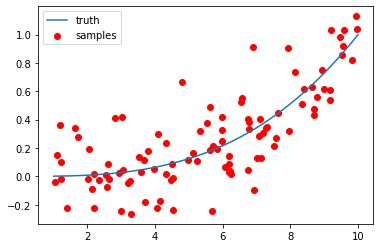

In [3]:
fsamples = f_sampler(f, 100, sigma=0.2)

xx = np.linspace(1,10,1000)
plt.plot(xx, f(xx), label="truth")
plt.scatter(*fsamples.T, color="red", label="samples")
plt.legend()
plt.show()

We can generate an infinite number of datasets (we have access to the blackbox) in this way. Let's consider 9 different datasets, call them $D_1,\dots,D_9$. Note that they are all generated from the same $f(x)$, which is the blue function in the plots, but due to the randomness in the noise, each of the datasets is different. In a learning problem, we will only have access to the dataset of the form $(x_i, y_i), i=1,\dots, n$ and the goal is to try to recover $f$ from this data. We usually denote our estimate of $f$ by putting a hat on the parameter of interest, i.e. $\hat{f}$. 

To estimate $f$, we usually try to put assumptions on the form of the unkown $f$. In the linear regression case for example, we make the simplifying assumption that $f(x)$ is a linear function.

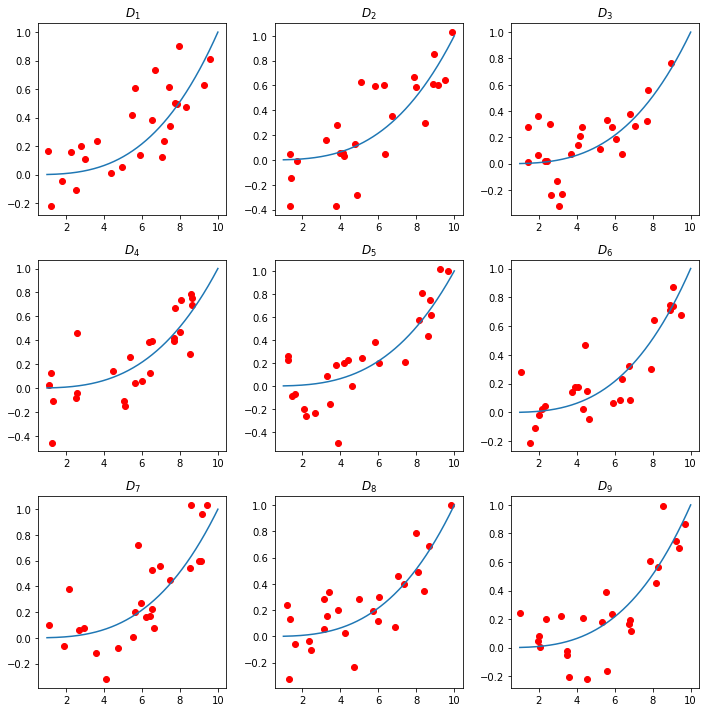

In [4]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
plt.tight_layout()
plt.show()

To understand bias and variance, the idea now will be to fit a model to each of the datasets, and see how the fits vary from dataset to dataset. A simple model to begin with is linear regression (with a single feature $x$). This model has high bias because it has a very strict assumption on the shape of the model, regardless of the data. It has low variance because models fit on different datasets will not vary too much. We can see this empirically for the 9 generated datasets, and we will plot the fitted models in green on each plot in the grid.

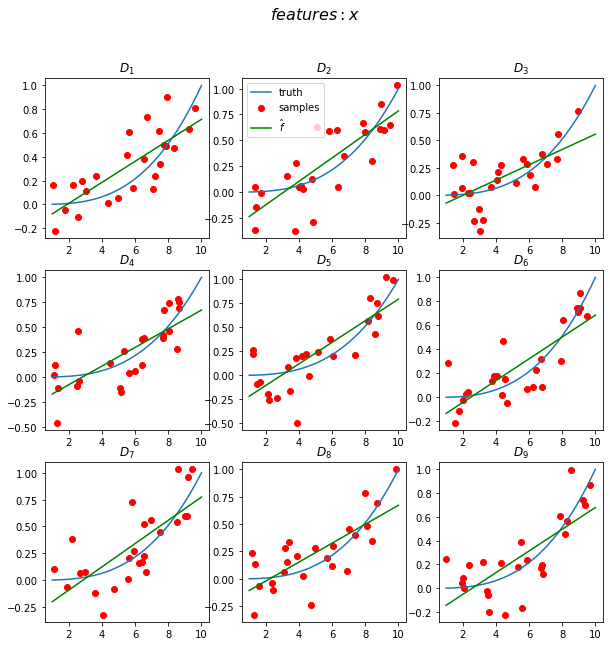

In [5]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 2))      # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0]*x
    # additonal dtype argument here avoids a depracation warning
    mods[i] = np.array([mod.intercept_[0], mod.coef_[0]], dtype='object')
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
    if i==1: ax.legend()
    
fig.suptitle("$features: x$", fontsize=16)
plt.show()

Note that the fitted model does not vary much from dataset to dataset. Linear models with a single feature do not have much ability to fit complicated trends in the data (they must be a straight line), and so will exhibit low variance, and high bias. Let's compute these quantities for our toy example at a single point, say $x_0 = 5$. 

The bias is the expected value of the model at $x_0$ minus the true value of $f$ at $x_0$, i.e. $f(x_0)$. Recall that in order to compute the expected value at $x_0$, we must be able to sample an infinite number of datasets, fit a model, then average. Here we will use the average of the predictions of the 9 models at $x_0$ as a proxy. To compute variance, we compute the variance of the predictions of all 9 models at $x_0$. We can see from the plot that linear regression has high bias, and low variance. Compare this picture to the picture we looked at earlier with the bias/variance targets.

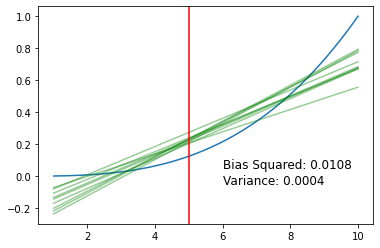

In [6]:
x0 = 5
x0_preds = np.zeros(9)
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0]+mods[i,1]*x
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    
    x0_preds[i] = lr(x0)
plt.axvline(x0, color="red")
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, 0.05), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.05), size=12, color='black')
plt.show()

The above plot shows the $9$ fitted models (in blue), and the true function $f$ in blue. We see that $x_0=5$, all $9$ models seem to do quite poorly as they are unable to fit the curvature in the true model. The bias here is high because the estimate is consistently far away from the truth. Note however that all $9$ models more or less predict the same value for $x_0$, and so exhibit very lower variance.

We can now investigate a more complex model by adding polynomial features to the linear regression. As we add higher order terms, we will be able to fit more complicated (curvy) functions. $\hat{y} = a + bx + cx^2$

<font color='purple'>
    
#### Exercise: 
Re-do the previous analysis, but now use both $x$ and $x^2$ when fitting the linear regression model. Create the same grid of plots as before but with your new model, and plot the bias and variance. What do you notice?

Hint: see the sklearn documentation here to get a better idea of how to fit a linear model with two covariates: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

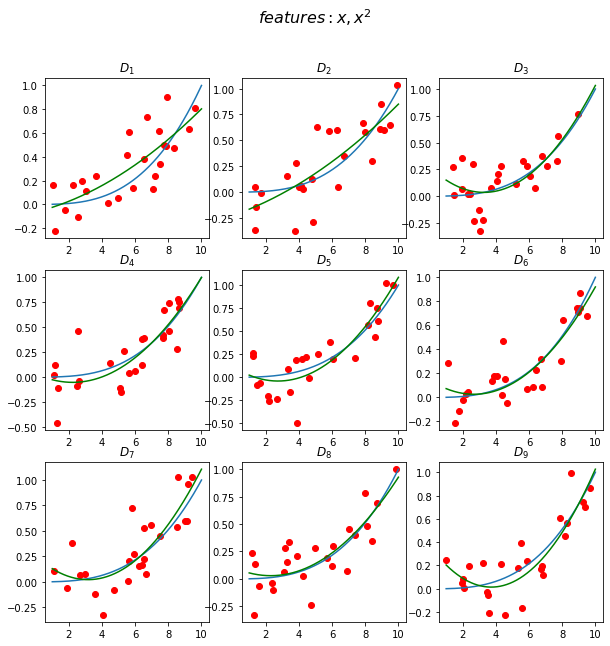

In [7]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 3))                                  # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    X = np.concatenate((X,X**2), axis=1)                # polynomial features
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0][0]*x + mod.coef_[0][1]*x**2
    mods[i] = np.array([mod.intercept_[0], *mod.coef_[0]])
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
fig.suptitle("$features: x, x^2$", fontsize=16)
plt.show()

Now that we have more flexibity (due to increasing the feature set to include quadratic terms), we see that learning algorithm can better fit the data, and we also see that there is slightly more variation across fits. Let's repeat our analysis above for $x_0=5$.

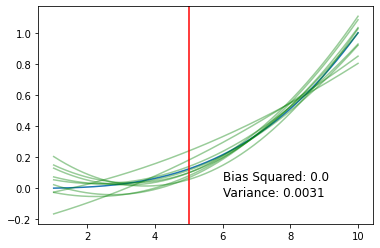

In [8]:
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0]+mods[i,1]*x+mods[i,2]*x**2
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    x0_preds[i] = lr(x0)
    
plt.axvline(x0, color="red")
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, 0.05), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.05), size=12, color='black')
plt.show()

<font color='purple'>
    
#### Exercise: 
Add more polynomial features: $a + bx + cx^2 + dx^3+ex^4 + fx^5 + g x^6$ and re-run the experiment. Comment on your results.

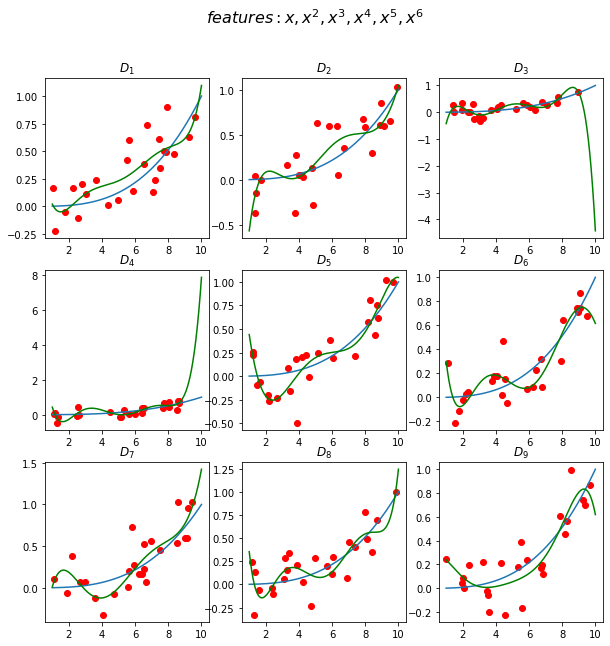

In [9]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 7))      # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    X = np.concatenate((X, X**2, X**3, X**4, X**5, X**6), axis=1)       # polynomial features
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0][0]*x + mod.coef_[0][1]*x**2 +\
    mod.coef_[0][2]*x**3 + mod.coef_[0][3]*x**4 + mod.coef_[0][4]*x**5 + + mod.coef_[0][5]*x**6
    mods[i] = np.array([mod.intercept_[0], *mod.coef_[0]])
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
    
fig.suptitle("$features: x, x^2, x^3, x^4, x^5, x^6$", fontsize=16)
plt.show()

Now the models have a very large amount of flexibility, and are able to fit more and more complex fits. We can see from the plot above that the fitted models vary greatly from dataset to dataset.

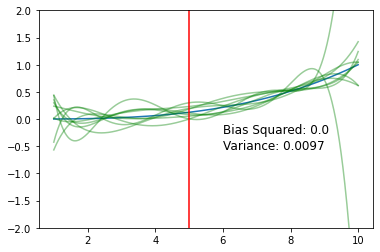

In [10]:
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0] + mods[i,1]*x + mods[i,2]*x**2 +\
    mods[i,3]*x**3 + mods[i,4]*x**4 + mods[i,5]*x**5 + + mods[i,6]*x**6
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    x0_preds[i] = lr(x0)
    
plt.axvline(x0, color="red")
plt.ylim(-2,2)
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, -0.25), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.55), size=12, color='black')
plt.show()

We see that as the complexity increases, so too does the variance. As we increase the complexity of the model, it has more and more flexibility to fit complex functions. The problem is that for different datasets, the models end up fitting the noise in the data. The high variance comes from the fact that for different datasets, we can get wildly different models. So there is a tradeoff here, which is known as the bias variance decomposition. If we want to reduce test error, then we want to be able to reduce the bias AND reduce the variance, but as we reduce bias sufficiently, the variance begins to increase.

<font color='purple'>
    
#### Advanced Exercise: 
Let's consider a more interesting function:

$$
f(x) = 0.00002 x^3 + 0.2 \cos(x^{1.2}).
$$

1. Generate 80 datasets from $f$ using $\sigma=0.1$ each of size $n=100$.
2. For each dataset, fit 9 models: the first model being a linear regression with degree 1, the second having both $x$ and $x^2$, and the final model having $x,\dots, x^9$ as features.
3. Create a 3x3 grid of plots, each sub-plot corresponding to a given degree (1-9). On each sub-plot, plot the true function in red, the 80 fitted functions in blue, and the average of the 80 fitted functions in yellow.
4. Now, using the above data, try to visualise the bias and variance at each of the points on the $x$-axis.
5. Comment.

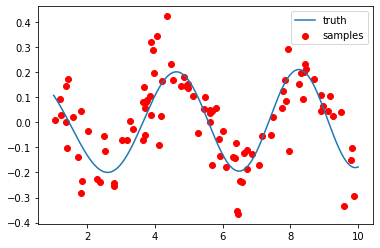

In [11]:
np.random.seed(10)

# true function
f = lambda x: 0.00002 * x**3 + 0.2 * np.cos(x**1.2)

fsamples = f_sampler(f, 100, sigma=0.1)

xx = np.linspace(1,10,1000)
plt.plot(xx, f(xx), label="truth")
plt.scatter(*fsamples.T, color="red", label="samples")
plt.legend()
plt.show()

In [12]:
nmb_datasets = 80
xx_len = 1000
np.random.seed(10)

# generate datasets
datasets = np.array([f_sampler(f, 25, sigma=0.2) for _ in range(nmb_datasets)])
xx = np.linspace(1,10, xx_len)

preds = np.zeros(shape=(9, nmb_datasets, xx_len)) # store all predictions for all models

for deg in range(1, 10):
    Xs = np.array([D[:,0].reshape(-1,1) for D in datasets])
    ys = np.array([D[:,1].reshape(-1,1) for D in datasets])
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    Xs = np.array([poly.fit_transform(X) for X in Xs])        # get polynomial feature matrix
    
    # fit models on all datasets
    lrs = np.array([LinearRegression().fit(X, y) for (X,y) in zip(Xs, ys)])
    
    # predictions on range xx 
    xx_poly = poly.fit_transform(xx.reshape(-1,1))
    preds[deg-1,:,:] = np.array([mod.predict(xx_poly) for mod in lrs]).reshape(nmb_datasets, xx_len)
    

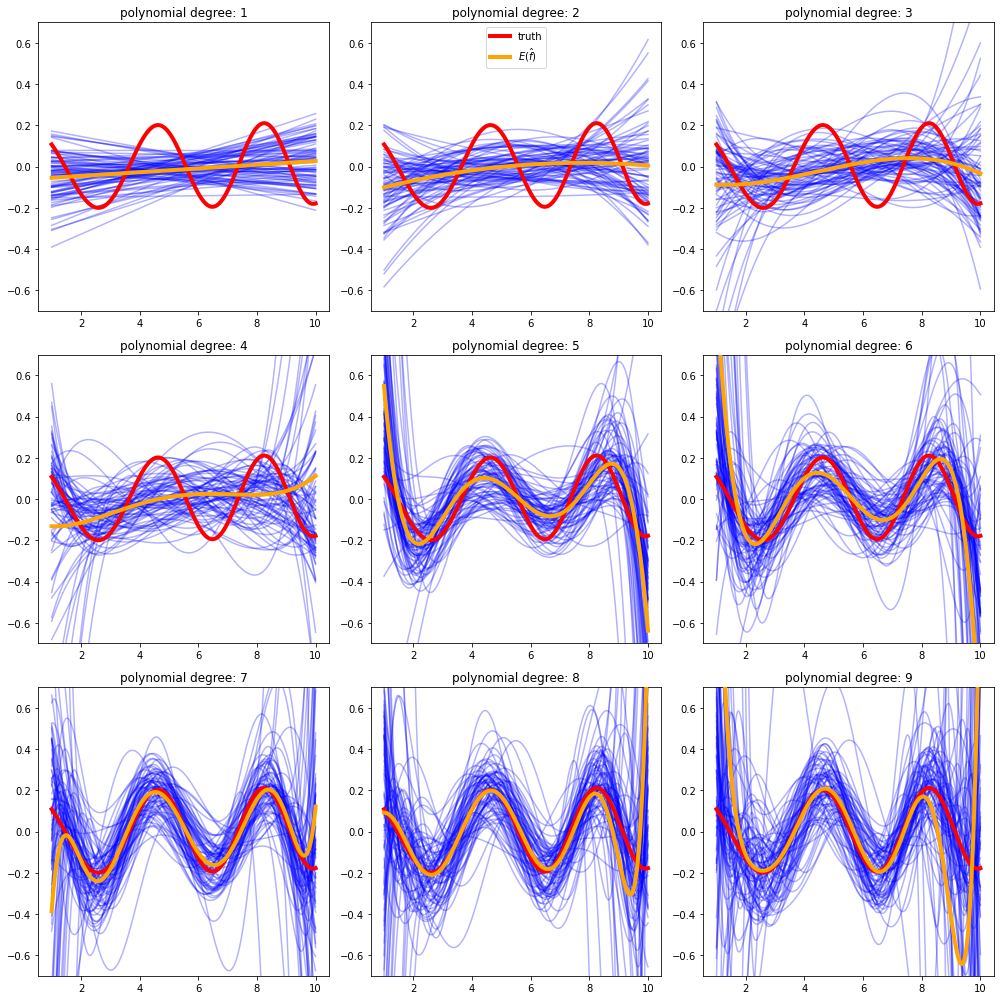

In [13]:
fig, ax = plt.subplots(3,3, figsize=(14,14))
truth = f(xx)
for j, ax in enumerate(ax.flat):
    avg_pred = np.mean(preds[j], axis=0)
    ax.plot(xx, truth, color="red", linewidth=4, zorder=20, label="truth")
    ax.plot(xx, avg_pred, color="orange", linewidth=4, zorder=20, label="$E(\\hat{f})$")    
    for i in range(nmb_datasets):
        ax.plot(xx, preds[j, i], alpha=0.3, color="blue", zorder=1)
        ax.set_title(f"polynomial degree: {j+1}")
        ax.set_ylim(-0.7,0.7)
    if j==1: ax.legend(loc="upper center")
plt.tight_layout()
plt.show()

Note that we should ignore the wild behaviour at the tails for this analysis, since this is caused by the way we build the model using linear regression. To get a better idea of the bias variance trade-off we should restrict attention to points in the middle 90\% or so.

In [14]:
variances = np.zeros(shape=(9, xx_len))
bias_sq = np.zeros(shape=(9, xx_len))
for i in range(9):
    variances[i,:] = np.var(preds[i], axis=0)
    bias_sq[i,:] = (np.mean(preds[i], axis=0) - f(xx))**2

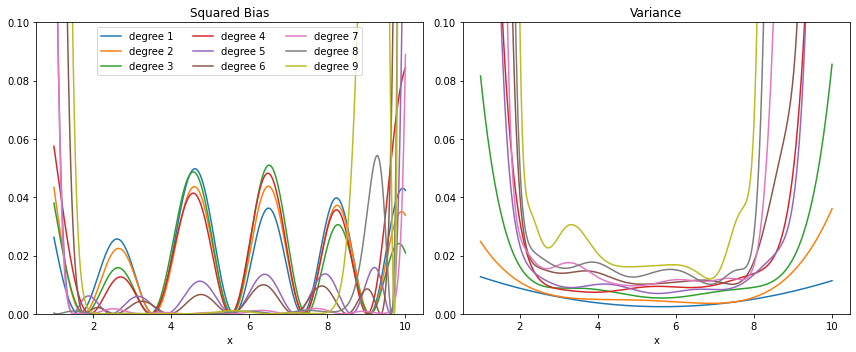

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
for i in range(9):
    ax1.plot(xx, bias_sq[i], label=f"degree {i+1}")
    ax2.plot(xx, variances[i])
    ax1.set_ylim(0,0.1)
    ax2.set_ylim(0,0.1)
    ax1.set_xlabel("x"); ax2.set_xlabel("x")
    ax1.set_title("Squared Bias")
    ax2.set_title("Variance")
ax1.legend(loc="upper center", ncol=3)
plt.tight_layout()

## Automatic Differentiation and a short intro to PyTorch

As discussed in the first tutorial, numerical techniques such as gradient descent are very important in machine learning, because they allow us to solve optimisation problems on the computer. This is particularly important when a closed form solution does not exist (we cannot write down a neat solution for the problem), or when computing the explicit solution is too expensive.

In this course, we will rely mainly on PyTorch when doing anything involving gradients. Pytorch is technically an `automatic differentiation (autodiff)` library, which means that it is able to compute gradients of functions numerically. PyTorch is primarily used for deep learning (which requires a form of differentiation called backpropagation), and we will see it again in later weeks (you may also want to use it for your project if doing something deep learning related).

The basic idea behind automatic differentiation is to decompose a function into simpler components and then apply the chain rule in a smart way. Let us consider a simple example to demonstrate the power of autodiff.

Consider the following complicated looking function:

$$
f(x) = \exp (\exp(x) + \exp(2x)) + \sin(\exp(x) + \exp(2x)).
$$

This looks quite complicated, but with a bit of work we can show that the derivative of $f$ is

$$
f'(x) = \exp (\exp(x) + \exp(2x))(\exp(x) + 2\exp(2x)) + \cos(\exp(x) + \exp(2x))(\exp(x) + 2\exp(2x))
$$

For those of you that attempted this by hand, you should see that the standard differentiation approach is somewhat wasteful, since we have the same factor $(\exp(x) + \exp(2x))$ in both expressions. Let's consider a more algorithmic approach. Define the following intermediate variables:

\begin{align*}
a &= \exp(x)\\
b &= a^2\\
c &= a+b\\
d &= \exp(c)\\
e &= \sin(c)\\
f &= d+e
\end{align*}

This may look strange at first, but we are basically rewriting $f(x)$ as an iterative procedure. We can represent this in graph form, using a structure known as a computational graph:

<img src="misc/f1.jpg">

The square nodes are computation nodes, they implement the functions they are named after, and the circular nodes are variable nodes, which store the intermediate variables. Viewing $g$ in this way allows us to compute the gradient in an iterative manner. We compute the derivatives of the intermediate variables with respect to their inputs:
\begin{align*}
\frac{\partial a}{\partial x} &= \exp(x)\\
\frac{\partial b}{\partial a} &= 2 a\\
\frac{\partial c}{\partial a} &= 1 = \frac{\partial c}{\partial b}\\
\frac{\partial d}{\partial c} &= \exp(c)\\
\frac{\partial e}{\partial c} &= \cos(c)\\
\frac{\partial f}{\partial d} &= 1 = \frac{\partial f}{\partial e}
\end{align*}

The goal is to compute $\frac{\partial g}{\partial x}$, we can do so by working our way backwards through the computation graph from the output node (node $f$) to the input node (node $x$). We first introduce the following notation $\text{child}(y)$ to denote the children of a node $y$. For example $\text{child}(c) = \{d, e\}$. Then, for any node $y$ in the graph, the chain rule tells us that

$$
\frac{\partial f}{\partial y} = \sum_{z \in \text{child}(y)} \frac{\partial f}{\partial z} \frac{\partial z}{\partial y}
$$

Let's apply this formula, we already have the partial derivatives of $f$ with respect to $d,e$ from above, so we start with $c$:

\begin{align*}
\frac{\partial f}{\partial c} &= \frac{\partial f}{\partial d}\frac{\partial d}{\partial c} + \frac{\partial f}{\partial e}\frac{\partial e}{\partial c} = 1 \times \exp(c) + 1 \times \cos (c)\\
\frac{\partial f}{\partial b} &= \frac{\partial f}{\partial c}\frac{\partial c}{\partial b} =\frac{\partial f}{\partial c} \times 1\\
\frac{\partial f}{\partial a} &= \frac{\partial f}{\partial b}\frac{\partial b}{\partial a} + \frac{\partial f}{\partial b}\frac{\partial b}{\partial a} = 
\frac{\partial f}{\partial b} \times 2 a + \frac{\partial f}{\partial c} \times 1\\
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial a} \frac{\partial a}{\partial x} = \frac{\partial f}{\partial a} \times \exp(x)
\end{align*}


Observe that the computation required for calculating the derivative is proportional to the computation required to calculate the function. You can visualise this process as if each node in the computational graph stores the derivatives of itself with respect to any child nodes, then to compute the gradient of the graph, we start from the output and work our way backwards, at each step re-using gradients computed earlier in the process. As you become more familiar with backpropagation, you should see that the two concepts are identical. Let's finalise our understanding by looking at a toy example using Pytorch. 

Since we have an excplicit form for the gradient, the goal will be to compare our explicit form to the solution computed numerically with PyTorch. Note that this is numerical differentiation, not symbolic, so the value of the gradient will change as we vary the input. We will compare the two results at the end.

In [16]:
import torch            # run "! pip3 install torch" in jupyter if you do not have torch

def func(x):
    t = np.exp(x) + np.exp(2*x)
    return np.exp(t) + np.sin(t)

def grad_func(x):
    t1 = np.exp(x) + np.exp(2*x)
    t2 = np.exp(x) + 2*np.exp(2*x)
    return t2 * (np.exp(t1) + np.cos(t1))

def sequential_func(x):
    inp = torch.tensor([[x]], dtype=torch.float64, requires_grad=True)
    a = torch.exp(inp)
    b = torch.pow(a, 2)
    c = a + b
    d = torch.exp(c)
    e = torch.sin(c)
    f = d + e
    f.backward()
    return inp.grad.item()

In [23]:
x_input = 0.2
print("explicit gradient: ", grad_func(x_input))
print("autograd gradient: ", sequential_func(x_input))

explicit gradient:  59.578079470554506
autograd gradient:  59.57807947055451


### Gradient Descent using PyTorch

We will now work through an extended example of performing gradient descent for a linear regression problem. We will first code this up manually using the results derived in tutorial 1. We will then sanity check our result by comparing it to the `sklearn` solution. We then implement gradient descent for the linear regression problem by hand, and finish off by re-implementing the model in `PyTorch`. Of course, for more complex models, such as deep neural nets, we will only be able to use `PyTorch` to compute answers efficiently.

First, let's generate some synthetic data for our problem:

In [24]:
np.random.seed(6)

n = 100                                                       # number of samples
p = 5                                                         # dimension of problem
sigma = 0.2                                                   # noise standard deviation
X = np.random.normal(0, 1, size=(n,p))                        # design matrix
betastar = np.random.randint(-4, 2, p)                        # true beta
noise = np.random.normal(0, sigma, size=(n))
y = X @ betastar + noise                                      # our data

#### Approach 1: by hand (using `NumPy`)
We know from Tutorial 1 that the optimal solution (the one that minimizes MSE) is given by:

$$
\hat{\beta} = (X^TX)^{-1}X^T y.
$$

We can easily code this up in `NumPy` and compare it to the true $\beta^*$.

In [25]:
betahat_np = np.linalg.inv(X.T @ X) @ X.T @ y
print("beta hat using numpy:  ", betahat_np)
print("           true beta:  ", betastar)

beta hat using numpy:   [ 0.97783793  0.01438534 -1.99131507 -3.9788805  -0.02356845]
           true beta:   [ 1  0 -2 -4  0]


#### Approach 2: using `sklearn`
In Lab 1 we have already explored the linear model object in `sklearn`.

In [26]:
from sklearn.linear_model import LinearRegression
betahat_sk = LinearRegression(fit_intercept=False).fit(X,y).coef_ 
print("beta hat using sklearn:  ", betahat_sk)
print("             true beta:  ", betastar)

beta hat using sklearn:   [ 0.97783793  0.01438534 -1.99131507 -3.9788805  -0.02356845]
             true beta:   [ 1  0 -2 -4  0]


#### Approach 3: gradient descent by hand
Recall that in gradient descent, we iteratively update the weight vector by doing:

$$
\hat{\beta}^{(k+1)} = \hat{\beta}^{(k)} - \eta \nabla_{\beta} L(\hat{\beta}^{(k)}).
$$

From Tutorial 1, we know that 

$$
\nabla_\beta L(\beta) = -2 X^T y + 2X^TX\beta,
$$

We will take $\eta=0.001$ as the step size, and we'll run gradient descent for T=50 iterations, and we'll initialize $\hat{\beta}^{(0)} = 0_p$, the zero vector in $p$ dimensions.

In [27]:
eta = 0.001
T = 50

def grad_loss(b, X, y):
    return -2 * X.T @ y + 2 * X.T @ X @ b

betas = np.zeros(shape=(T, p))                          # store the beta vec at each iteration

for t in range(1, T):
    betas[t,:] = betas[t-1,:] - eta * grad_loss(betas[t-1,:], X, y)
    
print("beta hat using GD by hand:  ", betas[T-1,:])
print("                true beta:  ", betastar)

beta hat using GD by hand:   [ 0.97707459  0.01357098 -1.99153047 -3.97745021 -0.02467584]
                true beta:   [ 1  0 -2 -4  0]


#### Approach 4: gradient descent with `PyTorch`
We now make use of `PyTorch` to compute the gradients - had we started here we would have had to do absolutely no calculus to compute the gradients required in approach 3, we would simply specify the objective we wish to optimize and let `PyTorch` do the rest. Obviously this is extremely useful when doing calculus by hand is hard (or impossible).

In `PyTorch` we use tensors rather than `NumPy`arrays. You can think of tensors as you do arrays; the only difference is that tensors allow you to compute gradients as we saw before. It is important to note here that in the following code, there is no equivalent of the `grad_loss` function, which is taken care of by the autodiff.

In [28]:
X_tensor =  torch.from_numpy(X).float()                           # X data tensor
y_tensor =  torch.from_numpy(y).float()                           # y data tensor
beta_tensor = torch.zeros(p, requires_grad=True)                  # this is our parameter vector beta
eta = 0.1
T = 50

for _ in range(T):
    yhat = X_tensor @ beta_tensor             # prediction of model
    residual = yhat - y_tensor                # residual tensor (errors)
    loss = (residual**2).mean()               # mean squared error tensor

    loss.backward()                           # this call computes gradients of `loss` w.r.t. any params (beta)tensor
    
    with torch.no_grad():
        # we do not want this calculation to be part of the gradient computation
        beta_tensor -= eta * beta_tensor.grad
    
    # remove current gradients from being stored (important if you want to recompute gradients)
    beta_tensor.grad.zero_()

print("beta hat using PyTorch:  ", beta_tensor.data)
print("             true beta:  ", betastar)

beta hat using PyTorch:   tensor([ 0.9772,  0.0137, -1.9915, -3.9776, -0.0245])
             true beta:   [ 1  0 -2 -4  0]


#### Approach 5: gradient descent with `PyTorch` but better
In approach 4, we used PyTorch but the computation was somewhat ad hoc. We now repeat the exercise but make use of more `PyTorch` functionality. 

Some things to note:
1. For any problem you wish to solve using `PyTorch`, you should first specify a `model` which inherits from the `Module` class and defines the model of computation you wish to work with. Importantly, this class always contains a `forward` function that describes how an input should make its way through the computational graph.

2. `PyTorch` already has a host of useful machine learning functions that can be imported. Many of these live in the `nn` module, which is short for `neural nets`.

3. `PyTorch` already has a large number of optimizers (other numerical methods apart from GD) that we can use. These live in the `optim` module

4. Throughout the course we will use similar classes to define various models.

In [29]:
from torch import nn, optim

# create the linear regression model class
class LinearRegressionTorch(nn.Module):
    def __init__(self):
        super().__init__()
        
        # need to wrap the params of the model in nn.Parameter
        self.beta_tensor = nn.Parameter(torch.zeros(p, requires_grad=True))
    
    def forward(self, X):
        return X @ self.beta_tensor

model = LinearRegressionTorch()                        # create a model instance
loss_func = nn.MSELoss()                               # choose MSE loss
optimizer = optim.SGD(model.parameters(), lr=eta)      # choose Stochastic GD

for _ in range(50):
    yhat = model.forward(X_tensor)
    loss = loss_func(y_tensor, yhat)
    loss.backward()
    optimizer.step()                                   # no need to manually update
    optimizer.zero_grad()

print("beta hat using PyTorch w model:  ", model.beta_tensor.data)
print("                     true beta:  ", betastar)

beta hat using PyTorch w model:   tensor([ 0.9772,  0.0137, -1.9915, -3.9776, -0.0245])
                     true beta:   [ 1  0 -2 -4  0]
